In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## Solving problem 
$$
\begin{array}{ll}
\text{minimize} & q(z) + h(x) \\
\text{subject to} & x = Az
\end{array}
$$

### Special case
$$
\begin{array}{ll}
\text{minimize} & g^\top z  \\
\text{subject to} & \|Az\|_{\max} \leq \beta 
\end{array}
$$
where $g \in \mathcal{R}(A^\top)$

## PDHG 
$$
\begin{aligned}
y^{t+1} &= \operatorname{prox}_{\rho h^*}\!\bigl(y^t + \rho\, A(2 z^t - z^{t-1})\bigr), \\
z^{t+1} &= \operatorname{prox}_{\gamma q}\!\bigl(z^t - \gamma A^\top y^{t+1}\bigr).
\end{aligned}
$$

Residuals
$$
\begin{aligned}
r_1^{t+1} &= \frac{1}{\rho}\left (y^{t+1} - y^t - \rho A(2z^t - z^{t-1} - z^{t+1})\right ) \\
r_2^{t+1} &= \frac{1}{\gamma} \left (z^{t+1} - z^t \right)
\end{aligned}
$$
The stopping cirterion is
$$
\begin{aligned}
 \|r_1^{t+1}\|_2 &\leq \sqrt{m} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|Az^{t+1}\|_2\\
 \|r_2^{t+1}\|_2 &\leq \sqrt{n} \, \epsilon^{\mathrm{abs}} + 
 \epsilon^{\mathrm{rel}} \|A^\top y^{t+1}\|_2.
\end{aligned}
$$


In [10]:
def prox_lin(x, g, gamma):
    # proximal operator for linear function <g, x>
    return x - gamma * g



def prox_l1(x, rho):
    # proximal operator for l1 norm rho * ||x||_1
    return np.sign(x) * np.maximum(np.abs(x) - rho, 0)  




def pdhg_method_A(prox_h_conj, prox_q, A, lamb_max=None, max_iter=100, eps_abs=1e-3, eps_rel=1e-3, stopping=False):
    if lamb_max is None: 
        lamb_max = np.linalg.norm(A, ord=2)

    rho, gamma = [1.0 / lamb_max] * 2
    m, n = A.shape
    residuals = {'r1': [], 'r2': [], 'r1_rel': [], 'r2_rel': []}
    for t in range(max_iter):
        if t == 0:
            z = np.zeros(A.shape[1])
            y = np.zeros(A.shape[0])
            z_bar = z.copy()

        y_new = prox_h_conj(y + rho * A @ z_bar, rho)
        z_new = prox_q(z - gamma * A.T @ y_new, gamma)
        
        if stopping:
            r1 = np.linalg.norm(y_new - y - rho * A @ (z_bar - z_new)) / rho
            r2 = np.linalg.norm(z_new - z) / gamma
            residuals['r1'] += [r1]
            residuals['r2'] += [r2]
            if t >= 1:
                residuals['r1_rel'] += [ (r1 - eps_abs * np.sqrt(m)) / np.linalg.norm(A @ z_new) ]
                residuals['r2_rel'] += [ (r2 - eps_abs * np.sqrt(n)) / np.linalg.norm(A.T @ y_new) ]
            if r1 <= eps_abs * np.sqrt(m) + eps_rel * np.linalg.norm(A @ z_new) \
                and r2 <= eps_abs * np.sqrt(n) + eps_rel * np.linalg.norm(A.T @ y_new):
                z = z_new
                y = y_new
                print(f"{t=}")
                break
        z_bar = 2 * z_new - z
        z = z_new
        y = y_new

    return z, y, residuals



def cvxpy_A(g, A, beta):
    z = cp.Variable(A.shape[1])
    objective = cp.Minimize(g.T @ z)
    constraints = [cp.norm(A @ z, "inf") <= beta]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    assert prob.status == "optimal"
    return z.value, constraints[0].dual_value


In [11]:
np.random.seed(0)
for (m, n) in [(50, 100), (100, 50)]:
    for _ in range(5):
        A = np.random.randn(m, n)
        g = A.T @ np.random.randn(m)
        beta = 1
        z0, y0 = cvxpy_A(g, A, beta) 

        prox_q = lambda x, gamma: prox_lin(x, g, gamma)
        prox_h_conj = lambda y, rho: prox_l1(y, rho * beta)

        z1, y1, residuals = pdhg_method_A(prox_h_conj, prox_q, A, max_iter=20000, eps_abs=1e-8, eps_rel=1e-8, stopping=True)
        assert np.allclose(z0.T @ g, z1.T @ g, atol=1e-3, rtol=1e-3), print(z0.T @ g, z1.T @ g)
        assert np.linalg.norm(A @ z1, np.inf) <= beta + 1e-2 and np.linalg.norm(A @ z0, np.inf) <= beta + 1e-2
        print("PASSED")

t=689
PASSED
t=886
PASSED
t=1016
PASSED
t=796
PASSED
t=812
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED


In [12]:
def plot_residuals(residuals):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    spec = [
        ('r1','r2','Absolute residuals', r'$r_1$', r'$r_2$'),
        ('r1_rel','r2_rel','Relative residuals', r'$r_1^{\text{rel}}$', r'$r_2^{\text{rel}}$')
    ]
    for i, (k1, k2, title, l1, l2) in enumerate(spec):
        d1, d2 = residuals.get(k1, []), residuals.get(k2, [])
        if len(d1) and len(d2):
            ax[i].plot(d1, label=l1); ax[i].plot(d2, label=l2)
            ax[i].set(yscale='log', title=title, xlabel='iteration')
            ax[i].grid(True, which='both', ls='--', alpha=0.4); ax[i].legend()
        else:
            ax[i].axis('off')
    plt.tight_layout()

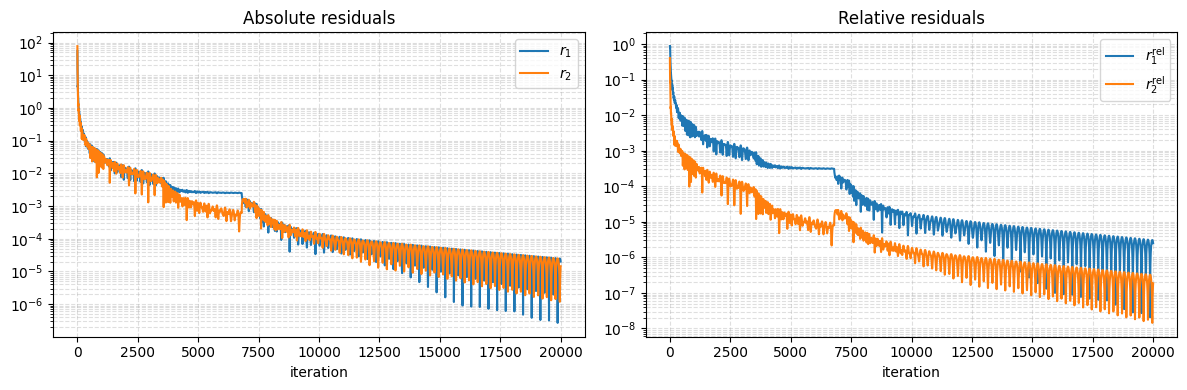

In [13]:
plot_residuals(residuals)

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )
\end{aligned}
$$


In [ ]:
def pdhg_method_AB(prox_h_conj, A, B, G1, G2, lamb_max=None, max_iter=100, eps_abs=1e-3, eps_rel=1e-3, stopping=False):
    if lamb_max is None: 
        lamb_max = (np.linalg.norm(A, ord=2)**2 + np.linalg.norm(B, ord=2)**2)**0.5

    rho, gamma = [1.0 / lamb_max] * 2
    m, n = A.shape
    residuals = {'r1': [], 'r2': [], 'r1_rel': [], 'r2_rel': []}
    for t in range(max_iter):
        if t == 0:
            Z1, Z2 = np.zeros(A.shape), np.zeros(A.shape)
            Y = np.zeros((n, n))
            Z1_bar = Z1.copy()
            Z2_bar = Z2.copy()

        Y_new = prox_h_conj(Y + rho * (Z1_bar.T @ B + A.T @ Z2_bar), rho)
        Z1_new = Z1 - gamma * (B @ Y_new.T + G1)
        Z2_new = Z2 - gamma * (A @ Y_new + G2)
        
        if stopping:
            r1 = np.linalg.norm(Y_new - Y - rho * (Z1_bar - Z1_new).T @ B - rho * A.T @ (Z2_bar - Z2_new)) / rho
            r2 = (np.linalg.norm(Z1_new - Z1)**2 + np.linalg.norm(Z2_new - Z2)**2)**0.5 / gamma
            residuals['r1'] += [r1]
            residuals['r2'] += [r2]
            normalization1 = (np.square(Z1_new.T @ B + A.T @ Z2_new).sum())**0.5
            normalization2 = (np.square(B @ Y_new.T).sum() + np.square(A @ Y_new).sum())**0.5
            if t >= 1:
                residuals['r1_rel'] += [ (r1 - eps_abs * np.sqrt(Y.size)) / normalization1 ]
                residuals['r2_rel'] += [ (r2 - eps_abs * np.sqrt(Z1.size + Z2.size)) / normalization2 ]
            if r1 <= eps_abs * np.sqrt(Y.size) + eps_rel * normalization1 \
                and r2 <= eps_abs * np.sqrt(Z1.size + Z2.size) \
                    + eps_rel * normalization2:
                Z1 = Z1_new
                Z2 = Z2_new
                Y = Y_new
                print(f"{t=}")
                break
        Z1_bar = 2 * Z1_new - Z1
        Z2_bar = 2 * Z2_new - Z2
        Z1 = Z1_new
        Z2 = Z2_new
        Y = Y_new

    return Z1, Z2, residuals



def cvxpy_AB(G1, G2, A, B, beta):
    Z1, Z2 = cp.Variable(A.shape), cp.Variable(B.shape)
    objective = cp.Minimize(cp.trace(G1.T @ Z1) + cp.trace(G2.T @ Z2))
    constraints = [cp.max(cp.abs(Z1.T @ B + A.T @ Z2)) <= beta]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    assert prob.status == "optimal", print(prob.status)
    return Z1.value, Z2.value

In [17]:
np.random.seed(0)
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        A = np.random.randn(m, n)
        B = np.random.randn(m, n)
        Y0 = np.random.randn(n, n)
        G1 = B @ Y0.T
        G2 = A @ Y0  

        beta = 0.5
        Z0_1, Z0_2 = cvxpy_AB(G1, G2, A, B, beta)
 
        prox_h_conj = lambda y, rho: prox_l1(y, rho * beta)

        Z1, Z2, residuals = pdhg_method_AB(prox_h_conj, A, B, G1, G2, max_iter=20000, eps_abs=1e-8, eps_rel=1e-8, stopping=True)
        assert np.allclose(np.trace(Z0_1.T @ G1 + Z0_2.T @ G2), np.trace(Z1.T @ G1 + Z2.T @ G2), atol=1e-3, rtol=1e-3)
        assert np.max(np.abs(Z1.T @ B + A.T @ Z2)) <= beta + 1e-2 and np.max(np.abs(Z0_1.T @ B + A.T @ Z0_2)) <= beta + 1e-2
        print("PASSED")

PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
PASSED
t=623
PASSED
t=623
PASSED
t=644
PASSED
t=644
PASSED
t=682
PASSED
t=682
PASSED
t=2397
PASSED
t=2397
PASSED
t=762
PASSED
t=762
PASSED


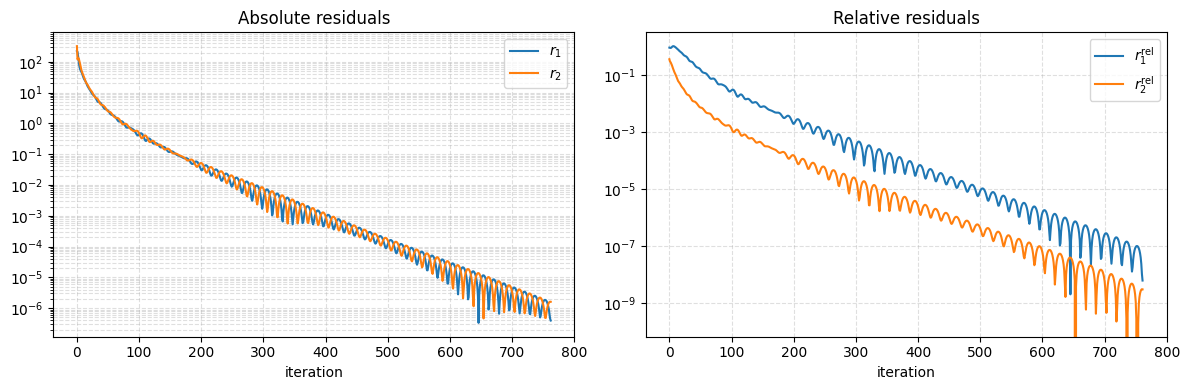

In [18]:
plot_residuals(residuals)